# Import Libraries

In [33]:
# standard library
import os
import re
import sys
import subprocess
import importlib.util

# third-party
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.regressionplots import plot_partregress
import joblib

# local imports
from scripts.helpers import map_to_color
from scripts.lower_dim import compute_pcs

from helper import *
from helper.analysis import build_effects_from_correlated_snps, gwas_linregress, summarize_component_fits, center_geno_by_ps, get_n_pcs
from helper.poly_analysis import polygenic_noise

In [34]:
def fit_line(x_, y_):
    slope, intercept, r, p, se = stats.linregress(x_, y_)
    neglogp = -np.log10(p) if p > 0 else np.inf
    return slope, intercept, neglogp

# Load data

In [35]:
geno, humans = load_data()

In [36]:
pheno = make_pheno(humans)

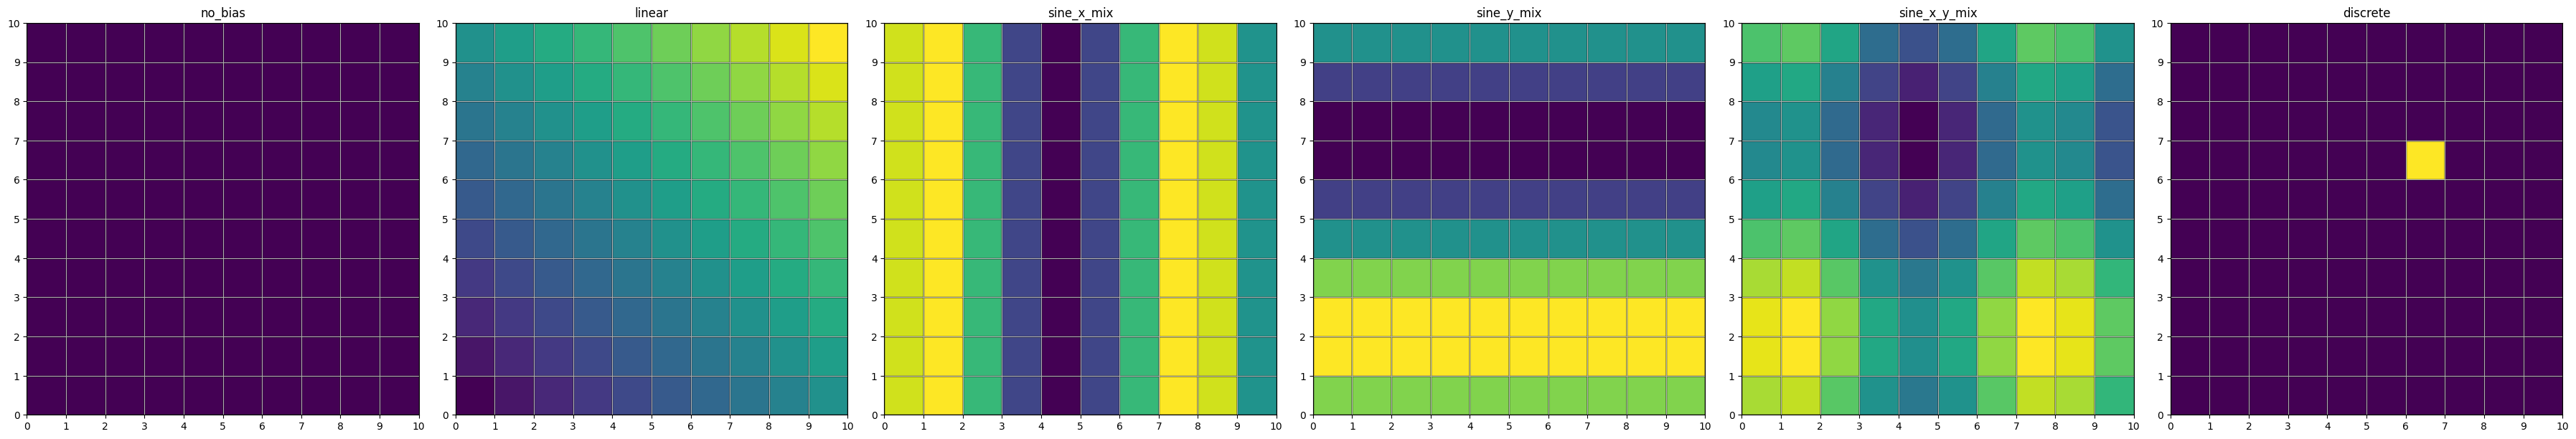

In [37]:
show_biases(pheno)

In [38]:
chosen_bias = "discrete"

In [39]:
G, snp_cols, pcs = _prep_geno_and_pcs(geno, PCs=5)
G.shape, len(snp_cols), pcs.shape

((2000, 8000), 8000, (2000, 5))

In [40]:
values, pcs, ps, HWE_dev = find_snps(geno, pop=humans["populations"], chosen_bias=pheno["discrete"], PCs=5)

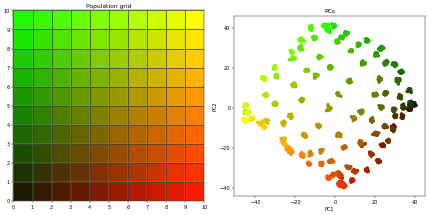

In [41]:
visualize_grid_and_pcs(pcs, humans, dpi=36, s=48)

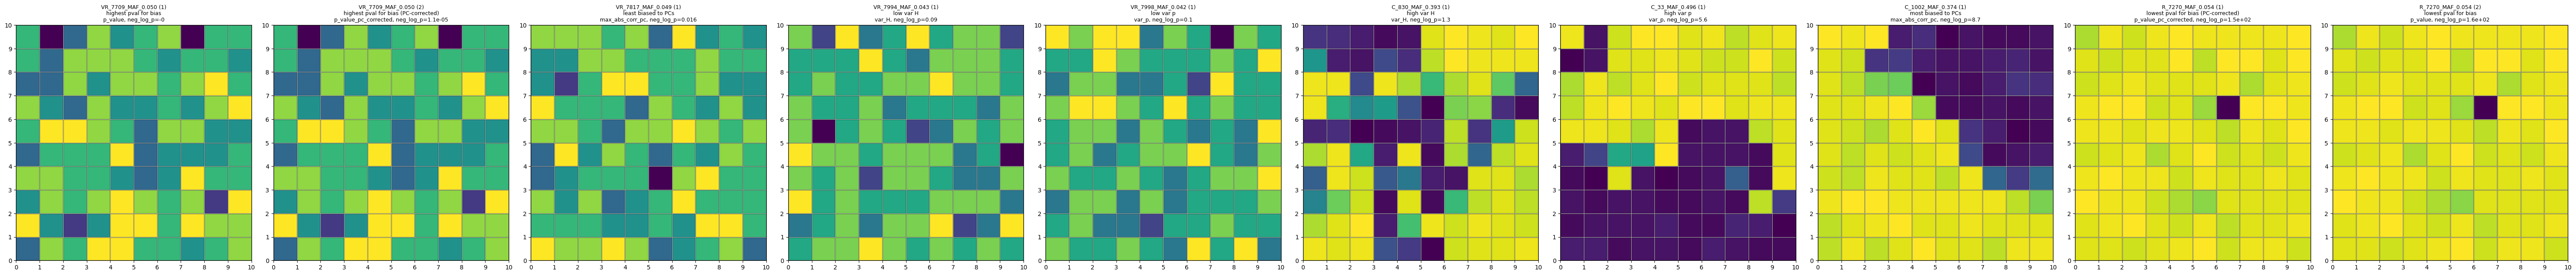

In [42]:
show_top_snps_ordered(humans, geno, values)

In [43]:
chosen_snp = values.loc[
    values["reasons"] == "lowest pval for bias (PC-corrected)", "names"
].iloc[0]

In [44]:
geno_std, std_params = standardize_and_return_params(geno)

In [45]:
mean_abs_corr, corr_df_sorted, correlated_snps = snp_correlation_analysis(
    geno_std,chosen_snp,
    top_k=5
)

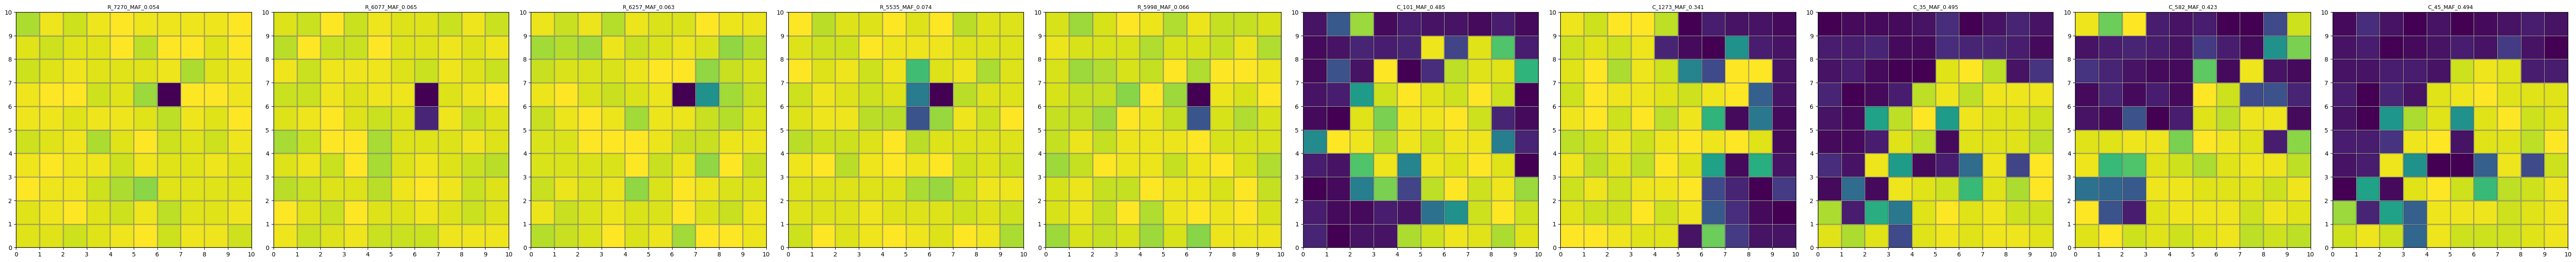

In [46]:
show_corr_snps_ordered(humans, geno, correlated_snps)

In [47]:
effects, chosen_corr = build_effects_from_correlated_snps(
    geno=geno,
    pheno=pheno,
    chosen_snp=chosen_snp,
    chosen_bias=chosen_bias,
    corr_df_sorted=corr_df_sorted,
    n_pos=2,
    n_neg=2,
    beta_snp=1,
    beta_pop=1,
)

summary = summarize_component_fits(geno, effects, chosen_snp, chosen_corr)
#display(summary)

gwas = gwas_linregress(geno, effects["pheno"])

In [48]:
beta_chosen_snp, intercept, neglogp = fit_line(geno[chosen_snp], effects['snp'])
beta_chosen_snp_std, intercept, neglogp = fit_line(geno_std[chosen_snp], effects['snp'])
beta_pos1 , intercept, neglogp = fit_line(geno[chosen_corr['pos'][0]], effects['c_pos1'])
beta_pos1_std , intercept, neglogp = fit_line(geno_std[chosen_corr['pos'][0]], effects['c_pos1'])
beta_pos2 , intercept, neglogp = fit_line(geno[chosen_corr['pos'][1]], effects['c_pos2'])
beta_pos2_std , intercept, neglogp = fit_line(geno_std[chosen_corr['pos'][1]], effects['c_pos2'])

beta_neg1 , intercept, neglogp = fit_line(geno[chosen_corr['neg'][0]], effects['c_neg1'])
beta_neg1_std , intercept, neglogp = fit_line(geno_std[chosen_corr['neg'][0]], effects['c_neg1'])
beta_neg2 , intercept, neglogp = fit_line(geno[chosen_corr['neg'][1]], effects['c_neg2'])
beta_neg2_std , intercept, neglogp = fit_line(geno_std[chosen_corr['neg'][1]], effects['c_neg2'])

In [49]:
# Polygenic noise

In [50]:
beta_poly = 1

g_noise, params_polygenic_noise, is_causal = (
    polygenic_noise(
        geno=geno,
        chosen_snp=chosen_snp,
        p_causal=0.01,
        total_beta=0.2,
        seed=1,
        regen=True,
    )
)

In [51]:
"""
# To check
# design matrix (same order as params_df)
cols = params_df["name_snps"].tolist()
G = geno[cols].to_numpy()

# extract parameters
true_beta_std = params_df["true_beta_std"].to_numpy()
true_intercept_std = params_df.attrs["true_intercept_std"]

# exact reconstruction check
np.allclose(
    g_noise,
    G @ true_beta_std + true_intercept_std,
    atol=1e-6,
)
"""

'\n# To check\n# design matrix (same order as params_df)\ncols = params_df["name_snps"].tolist()\nG = geno[cols].to_numpy()\n\n# extract parameters\ntrue_beta_std = params_df["true_beta_std"].to_numpy()\ntrue_intercept_std = params_df.attrs["true_intercept_std"]\n\n# exact reconstruction check\nnp.allclose(\n    g_noise,\n    G @ true_beta_std + true_intercept_std,\n    atol=1e-6,\n)\n'

In [52]:
effects['poly_noise'] = g_noise
effects = effects.drop(columns=["pheno"])

In [53]:
effects['total_pre_pop'] = effects['snp']+effects['poly']+effects['poly_noise']
effects['total'] = effects['total_pre_pop']+effects['pop']

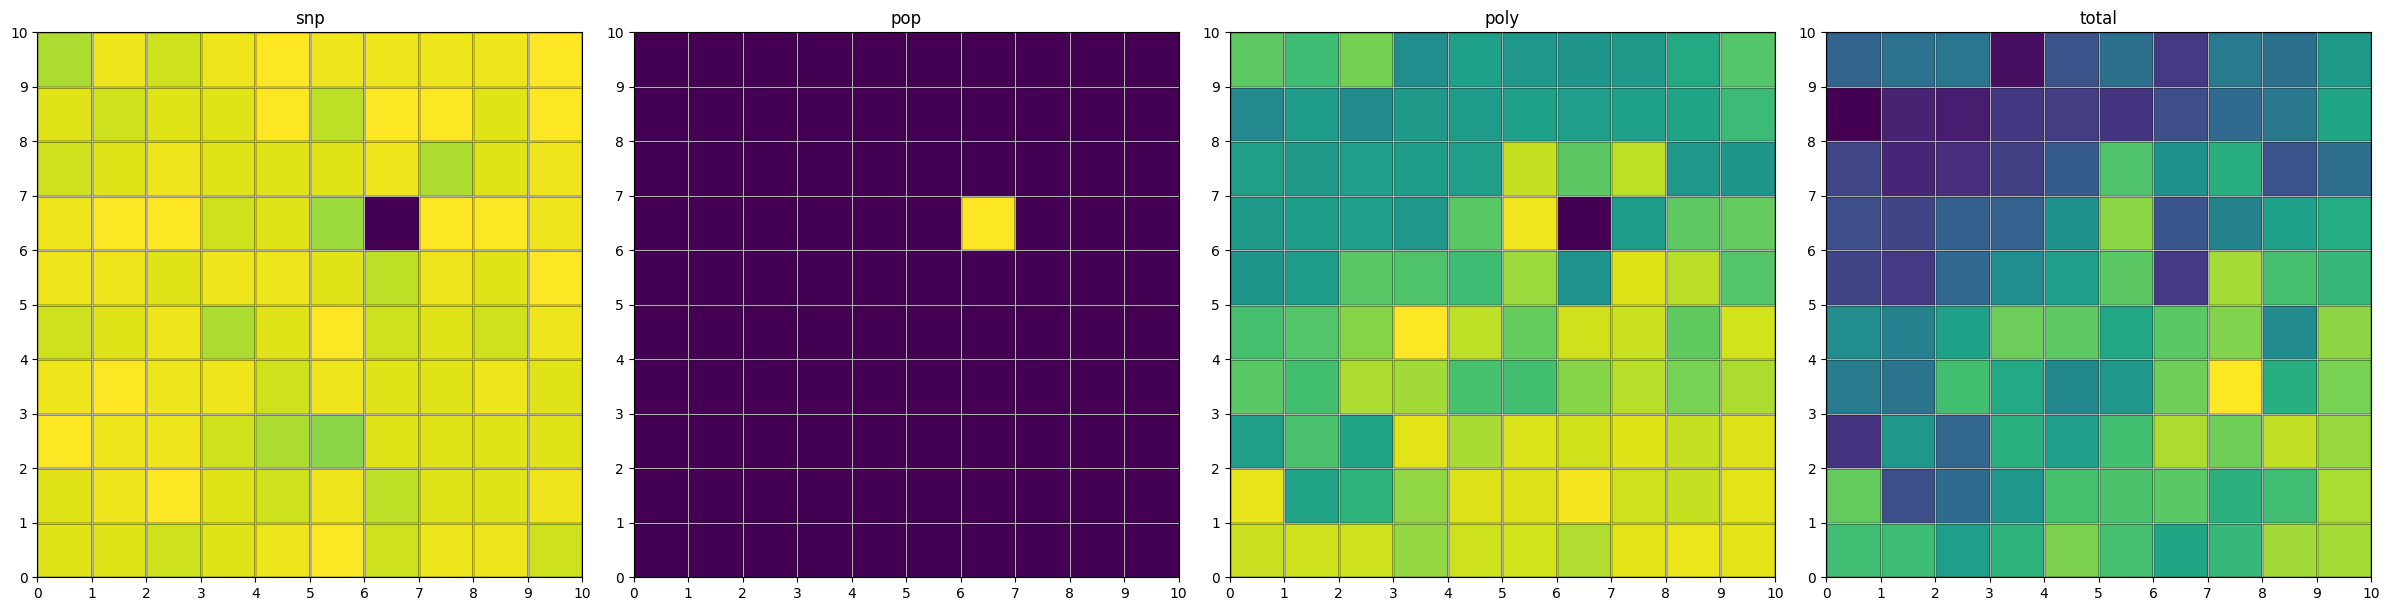

In [54]:
plot_effects(pheno, effects)

In [55]:
poly_snps = list(params_polygenic_noise.name_snps)
perceived_beta = []
neglops = []
for snp in poly_snps:
    slope, intercept, neglogp = fit_line(geno[snp], effects['total_pre_pop'])
    perceived_beta.append(intercept)
    neglops.append(neglogp)

In [56]:
params_polygenic_noise['perceived_beta_pre_pop'] = perceived_beta
params_polygenic_noise['neglop_perceived_pre_pop'] = neglops

In [57]:
poly_snps = list(params_polygenic_noise.name_snps)
perceived_beta = []
neglops = []
for snp in poly_snps:
    slope, intercept, neglogp = fit_line(geno[snp], effects['total'])
    perceived_beta.append(intercept)
    neglops.append(neglogp)

params_polygenic_noise['perceived_beta_with_pop'] = perceived_beta
params_polygenic_noise['neglop_perceived_with_pop'] = neglops

In [58]:
def set_true_beta(df, snp_name, beta_value, beta_std_value):
    mask = df["name_snps"] == snp_name

    beta_dtype = df["true_beta"].dtype
    beta_std_dtype = df["true_beta_std"].dtype

    df.loc[mask, "true_beta"] = beta_dtype.type(beta_value)
    df.loc[mask, "true_beta_std"] = beta_std_dtype.type(beta_std_value)

    return df

In [59]:
params_polygenic_noise = set_true_beta(params_polygenic_noise, chosen_snp, beta_chosen_snp, beta_chosen_snp_std)
params_polygenic_noise = set_true_beta(params_polygenic_noise, chosen_corr['pos'][0], beta_pos1, beta_pos1_std)
params_polygenic_noise = set_true_beta(params_polygenic_noise, chosen_corr['pos'][1], beta_pos2, beta_pos2_std)
params_polygenic_noise = set_true_beta(params_polygenic_noise, chosen_corr['neg'][0], beta_neg1, beta_pos1_std)
params_polygenic_noise = set_true_beta(params_polygenic_noise, chosen_corr['neg'][1], beta_neg2, beta_neg2_std)


In [60]:
params_polygenic_noise["beta_marginal_effect"] = params_polygenic_noise["perceived_beta_pre_pop"] - params_polygenic_noise["true_beta"]

In [61]:
params_polygenic_noise[params_polygenic_noise['true_beta']>0]

,name_snps,true_beta,true_beta_std,perceived_beta_pre_pop,neglop_perceived_pre_pop,perceived_beta_with_pop,neglop_perceived_with_pop,beta_marginal_effect
44,C_45_MAF_0.494,2.144374,1.000000,-1.540636,125.361331,-1.656160,186.335986,-3.685010
218,C_219_MAF_0.473,0.011179,0.213007,-0.008996,0.045086,-0.107197,0.980796,-0.020175
276,C_277_MAF_0.463,0.002796,0.053266,1.078114,48.843843,1.197118,74.281610,1.075319
498,C_499_MAF_0.432,0.012844,0.244725,-0.852790,27.851865,-0.947414,41.686007,-0.865634
581,C_582_MAF_0.423,2.192271,1.000000,-1.782237,122.887699,-1.879227,173.942182,-3.974508
680,C_681_MAF_0.413,0.009939,0.189370,-0.456860,7.573854,-0.560795,13.289825,-0.466799
931,C_932_MAF_0.383,0.006599,0.125726,-0.048168,0.239789,-0.154421,1.314292,-0.054766
984,C_985_MAF_0.376,0.006962,0.132642,0.489737,7.579748,0.389153,5.920595,0.482775
989,C_990_MAF_0.375,0.013030,0.248265,0.501986,7.893630,0.400973,6.219783,0.488956
1066,C_1067_MAF_0.365,0.003835,0.073076,-1.437115,57.337284,-1.342610,60.622610,-1.440951


In [62]:
snps_pcs = get_n_pcs(geno.T, 50)

In [63]:
snps_pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
C_1_MAF_0.500,-42.306241,-7.895576,-22.541839,-9.903447,-15.254347,11.723228,3.337513,6.040030,12.781781,-3.469872,...,-1.222886,-2.282482,5.201376,1.559247,10.795621,-8.857097,0.797309,4.616738,-3.189827,-0.129035
C_2_MAF_0.500,-41.467486,-7.531033,3.497390,-40.722345,3.539106,-13.648822,-3.532028,-3.378289,4.476905,-6.310626,...,0.774619,1.033161,0.125867,-5.003651,-3.278296,-9.413489,-0.843902,4.472173,-1.174475,5.460241
C_3_MAF_0.500,-40.754501,-47.626649,-0.354487,-7.017261,-17.735619,-12.507283,3.404363,2.879356,-1.203975,-4.560792,...,0.493312,-0.871721,-3.554397,-3.467868,-2.611998,-1.708674,2.276412,-3.169791,-2.329391,-1.587488
C_4_MAF_0.500,-41.532767,-7.596417,4.274121,-40.844438,3.344807,-13.354054,-5.195071,-4.702099,3.251352,-5.689277,...,0.804552,1.093504,0.762299,-4.314746,-2.924996,-9.303634,-2.860967,5.085614,-2.479150,8.056993
C_5_MAF_0.500,-44.622712,0.225075,-7.051896,38.748800,-3.218870,11.955947,5.682298,2.784111,-2.848893,6.902249,...,1.310533,-0.687779,1.355246,4.819329,4.701232,9.679564,2.322385,-3.205121,2.978602,-5.787251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VR_7996_MAF_0.042,17.229304,1.209694,1.335663,0.103234,-0.278565,-0.470982,-0.084950,0.651517,0.277014,0.014692,...,-0.105080,0.004199,-0.101513,-0.629089,-0.043958,0.711567,-0.073961,0.093983,-0.174721,0.644097
VR_7997_MAF_0.042,17.202664,1.502709,0.527580,0.052821,-1.349014,0.355752,-0.874103,0.067545,-0.662019,0.145217,...,0.321309,0.823657,0.261405,0.558111,0.426920,-0.335046,0.289307,0.228643,-0.555561,-0.322994
VR_7998_MAF_0.042,17.168957,0.915893,1.635721,1.099380,-0.881167,0.787027,-0.266246,-0.070485,-0.048227,0.290370,...,0.193849,0.009594,0.175303,-0.554339,-0.497739,-0.355930,-0.265307,0.242028,-0.363082,0.544354
VR_7999_MAF_0.042,17.222657,1.503773,1.920215,-0.050273,-0.696838,0.904704,0.237641,0.272000,0.225052,0.075500,...,-0.183209,0.259768,0.238938,0.281642,0.419038,-0.047581,-0.750518,-0.021455,-0.761470,0.006178


In [64]:
chosen_vec = snps_pcs.loc[chosen_snp].values

In [66]:
# matrix of all SNP PC coordinates
all_vecs = snps_pcs.values  # shape: (8000, 50)
# Euclidean distances to the chosen SNP
distances = np.linalg.norm(all_vecs - chosen_vec, axis=1)

In [68]:
distances

array([76.23512633, 80.70768513, 80.99017569, ..., 10.7421287 ,
       10.49175421, 10.56443308])

In [32]:
most_explainable_pcs = gwas_linregress(snps_pcs, gwas["beta"])
most_explainable_pcs = most_explainable_pcs.sort_values(by="neglog10p", ascending=False)

In [33]:
top_2_pcs = list(most_explainable_pcs.head(2)['snp'])

In [34]:
top_pcs = snps_pcs[top_2_pcs]
top_pcs = top_pcs.join(
    gwas.set_index("snp")["beta"]
)
top_pcs = top_pcs.sort_values(by="beta", ascending=True)

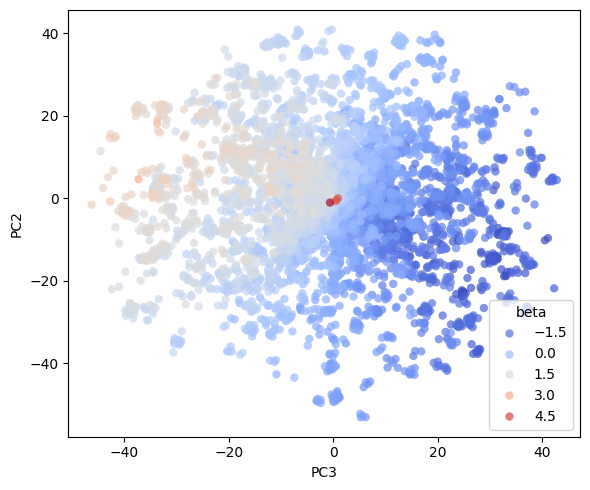

In [35]:


plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=top_pcs,
    x=top_2_pcs[0],
    y=top_2_pcs[1],
    hue="beta",
    palette="coolwarm",
    linewidth=0,
    alpha=0.7
)

plt.tight_layout()
plt.show()


In [36]:
geno_corr = geno - ((ps - (1-ps))+1)/2

In [37]:
snps_corr_pcs = get_n_pcs(geno_corr.T, 50)

In [38]:
gwas_corr = gwas_linregress(geno_corr, effects["total"])

In [39]:
most_explainable_pcs_corr = gwas_linregress(snps_corr_pcs, gwas_corr["beta"])
most_explainable_pcs_corr = most_explainable_pcs_corr.sort_values(by="neglog10p", ascending=False)

In [40]:
top_2_pcs_corr = list(most_explainable_pcs_corr.head(2)['snp'])

In [41]:
top_pcs_corr = snps_corr_pcs[top_2_pcs_corr]
top_pcs_corr = top_pcs_corr.join(
    gwas_corr.set_index("snp")["beta"]
)
top_pcs_corr = top_pcs_corr.sort_values(by="beta", ascending=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=top_pcs_corr,
    x=top_2_pcs_corr[0],
    y=top_2_pcs_corr[1],
    hue="beta",
    palette="coolwarm",
    linewidth=0,
    alpha=0.7
)

plt.tight_layout()
plt.show()


1.00525

In [47]:

test = np.sqrt(
    (p[top_corr_snp_name] * (1 - p[top_corr_snp_name])) /
    (p[chosen_snp] * (1 - p[chosen_snp]))
)


In [48]:
test

0       0.71635
1       0.71635
2       0.71635
3       0.71635
4       0.71635
         ...   
1995        inf
1996        inf
1997        inf
1998        inf
1999        inf
Length: 2000, dtype: float64

In [46]:
leakage = r * test

NameError: name 'r' is not defined

In [34]:
diff = 1-(2*p[chosen_snp]-2*p[top_corr_snp_name])
1-diff.mean()

0.02300000000000002

In [32]:
p

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.499,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_7991_MAF_0.043,VR_7992_MAF_0.043,VR_7993_MAF_0.043,VR_7994_MAF_0.043,VR_7995_MAF_0.042,VR_7996_MAF_0.042,VR_7997_MAF_0.042,VR_7998_MAF_0.042,VR_7999_MAF_0.042,VR_8000_MAF_0.042
0,0.95,0.950,0.900,1.000,0.05,0.025,0.075,0.95,0.05,0.95,...,0.925,0.975,0.975,0.95,0.900,0.925,0.925,0.975,0.900,1.000
1,0.95,0.950,0.900,1.000,0.05,0.025,0.075,0.95,0.05,0.95,...,0.925,0.975,0.975,0.95,0.900,0.925,0.925,0.975,0.900,1.000
2,0.95,0.950,0.900,1.000,0.05,0.025,0.075,0.95,0.05,0.95,...,0.925,0.975,0.975,0.95,0.900,0.925,0.925,0.975,0.900,1.000
3,0.95,0.950,0.900,1.000,0.05,0.025,0.075,0.95,0.05,0.95,...,0.925,0.975,0.975,0.95,0.900,0.925,0.925,0.975,0.900,1.000
4,0.95,0.950,0.900,1.000,0.05,0.025,0.075,0.95,0.05,0.95,...,0.925,0.975,0.975,0.95,0.900,0.925,0.925,0.975,0.900,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.45,0.925,0.025,0.975,0.05,0.950,0.050,0.00,0.05,0.05,...,0.975,0.950,0.900,0.90,0.975,1.000,0.975,0.950,0.925,0.975
1996,0.45,0.925,0.025,0.975,0.05,0.950,0.050,0.00,0.05,0.05,...,0.975,0.950,0.900,0.90,0.975,1.000,0.975,0.950,0.925,0.975
1997,0.45,0.925,0.025,0.975,0.05,0.950,0.050,0.00,0.05,0.05,...,0.975,0.950,0.900,0.90,0.975,1.000,0.975,0.950,0.925,0.975
1998,0.45,0.925,0.025,0.975,0.05,0.950,0.050,0.00,0.05,0.05,...,0.975,0.950,0.900,0.90,0.975,1.000,0.975,0.950,0.925,0.975


In [18]:
top_corr_snp_name

'R_7270_MAF_0.054'

In [19]:
beta_snp = 0.5
beta_pop = 1
beta_poly = 1

g_noise, beta, is_causal = polygenic_noise(
    geno,
    chosen_snp=chosen_snp,
    p_causal=0.1,
    total_beta=beta_poly,
    seed=1,
    regen=True,
    cache_path="g_noise.npz"
)

In [20]:
effects = pd.DataFrame(index=geno.index)

snp_term  = geno[chosen_snp].astype(float)          # 0, 0.5, 1
pop_term  = pheno[chosen_bias].astype(float)        # 0..1
poly_term = pd.Series(g_noise, index=geno.index)    # already ~N(0,1), but ok to re-standardize

def z(x):
    #return x
    return (x - x.mean()) / (x.std() + 1e-8)

effects["snp"]  = beta_snp  * z(snp_term)
effects["pop"]  = beta_pop  * z(pop_term)
effects["poly"] = beta_poly * z(poly_term)

effects["total"] = effects["snp"] + effects["pop"] + effects["poly"]

In [21]:
def fit_line(x_, y_):
    slope, intercept, r, p, se = stats.linregress(x_, y_)
    neglogp = -np.log10(p) if p > 0 else np.inf
    return slope, intercept, neglogp
slope_snp, intercept_snp, neglogp_snp = fit_line(geno[chosen_snp],effects["snp"])
slope_pop, intercept_pop, neglogp_pop = fit_line(geno[chosen_snp],effects["pop"])
slope_poly, intercept_poly, neglogp_poly = fit_line(geno[chosen_snp],effects["poly"])

print(
    f"{'Effect':<6} | {'Slope':>8} | {'Intercept':>10} | {'-log10(p)':>10}\n"
    f"{'-'*45}\n"
    f"{'SNP':<6} | {slope_snp:8.4f} | {intercept_snp:10.4f} | {neglogp_snp:10.2f}\n"
    f"{'POP':<6} | {slope_pop:8.4f} | {intercept_pop:10.4f} | {neglogp_pop:10.2f}\n"
    f"{'POLY':<6} | {slope_poly:8.4f} | {intercept_poly:10.4f} | {neglogp_poly:10.2f}"
)


Effect |    Slope |  Intercept |  -log10(p)
---------------------------------------------
SNP    |   0.4999 |     0.0000 |        inf
POP    |  -0.5491 |    -0.0000 |     157.24
POLY   |  -0.0202 |    -0.0000 |       0.44


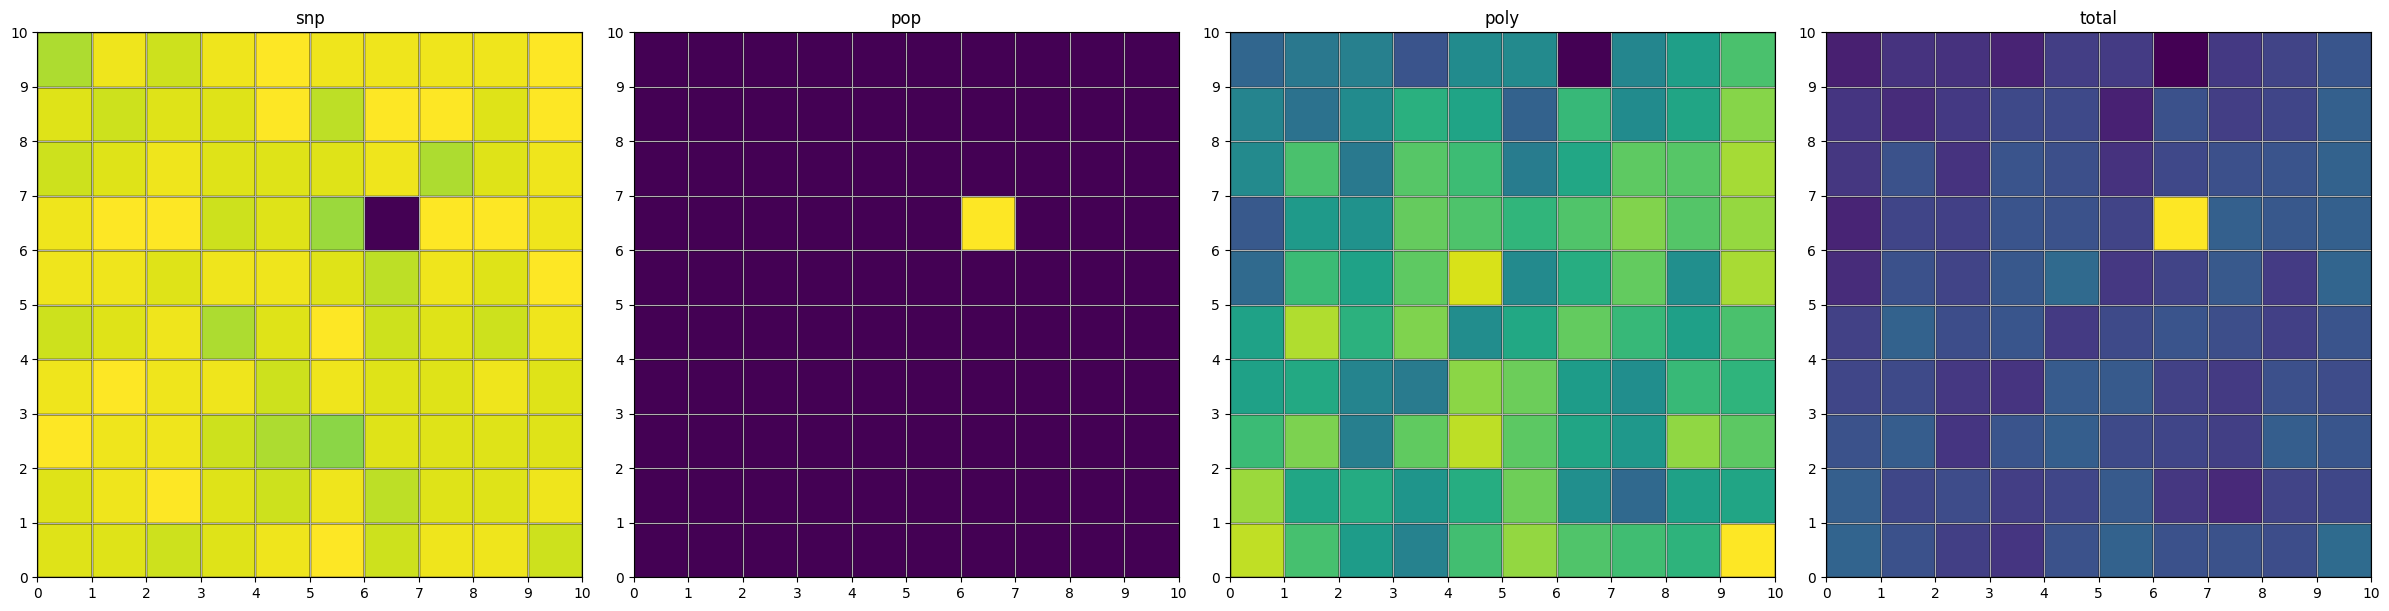

In [22]:
plot_effects(pheno, effects)

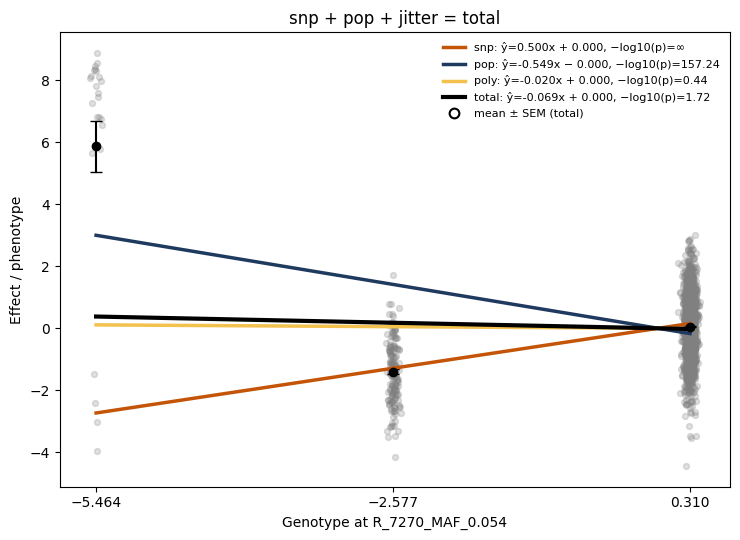

In [23]:
params = plot_components_vs_snp(geno, chosen_snp, effects)

In [24]:
params

{'snp': {'beta': 0.49987497937359227,
  'intercept': 8.346301002741667e-17,
  'neglogp': inf},
 'pop': {'beta': -0.5490613013496987,
  'intercept': -1.4866527734469956e-16,
  'neglogp': 157.24043329508578},
 'poly': {'beta': -0.020240635014883372,
  'intercept': 5.690089850888681e-10,
  'neglogp': 0.43711710109109636},
 'total': {'beta': -0.06942695699098819,
  'intercept': 5.690089714009491e-10,
  'neglogp': 1.7200814570132497}}

In [43]:
corr = ((p-(1-p)+1)/2)
corr = (corr - snp_mean) / snp_std

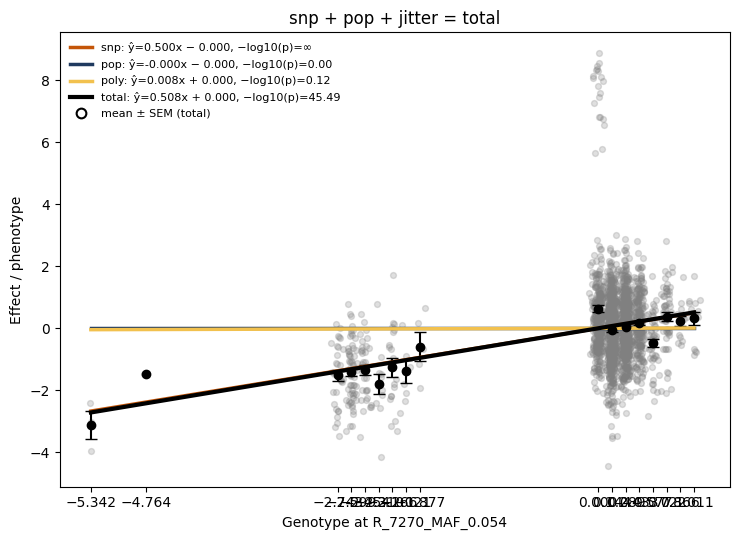

In [47]:
params_corr = plot_components_vs_snp(geno-corr, chosen_snp, effects)

In [48]:
# For all other SNPs now

In [49]:
effects["total_minus_snp_effect"] = effects["total"] - params_corr['total']['beta']*geno[chosen_snp]

In [50]:
len(geno.columns.drop(chosen_snp))

7999

In [51]:
rows = []
to_use = geno-corr
for snp in geno.columns.drop(chosen_snp):
    slope, intercept, neglogp = fit_line(
        to_use[snp],
        effects["total_minus_snp_effect"]
    )
    rows.append({
        "snp": snp,
        "slope": slope,
        "intercept": intercept,
        "neglogp": neglogp
    })

vals = pd.DataFrame(rows)


In [52]:
vals

,snp,slope,intercept,neglogp
0,C_1_MAF_0.500,-0.044497,5.690091e-10,0.275639
1,C_2_MAF_0.500,-0.032664,5.690091e-10,0.167299
2,C_3_MAF_0.500,0.049859,5.690091e-10,0.261097
3,C_4_MAF_0.500,-0.085440,5.690091e-10,0.545852
4,C_5_MAF_0.500,-0.034113,5.690091e-10,0.169625
...,...,...,...,...
7994,VR_7996_MAF_0.042,0.005578,5.690091e-10,0.062061
7995,VR_7997_MAF_0.042,0.022066,5.690091e-10,0.297539
7996,VR_7998_MAF_0.042,-0.010438,5.690091e-10,0.124557
7997,VR_7999_MAF_0.042,0.003156,5.690091e-10,0.034245


In [53]:
error_beta = params_corr['total']['beta']-params_corr['snp']['beta']
error_beta

0.00833875987434246

In [54]:
vals['slope'].mean()

-0.0003172816860716118

In [55]:
vals["slope"].sum()

-2.5379362068868225

In [35]:
def plot_components_vs_x(x, y, covs=None, jitter=0.03):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from scipy import stats

    if covs is None:
        covs = []

    # coerce x
    x = np.asarray(x, dtype=float)

    # coerce y into a dict of named components
    if isinstance(y, dict):
        ys = {k: np.asarray(v, dtype=float) for k, v in y.items()}
    else:
        ys = {"total": np.asarray(y, dtype=float)}

    # coerce covariates (currently only for NaN-alignment)
    covs = [np.asarray(c, dtype=float) for c in covs]

    # build joint matrix for NaN filtering
    X = np.column_stack([x] + list(ys.values()) + covs)
    X = X[~np.isnan(X).any(axis=1)]

    x = X[:, 0]
    n_y = len(ys)
    y_keys = list(ys.keys())
    ys = {k: X[:, i + 1] for i, k in enumerate(y_keys)}
    covs = [X[:, 1 + n_y + i] for i in range(len(covs))]  # kept for future use

    def fit_line(x_, y_):
        slope, intercept, r, p, se = stats.linregress(x_, y_)
        neglogp = -np.log10(p) if p > 0 else np.inf
        return slope, intercept, neglogp

    def pretty(name, slope, intercept, neglogp):
        ptxt = "∞" if np.isinf(neglogp) else f"{neglogp:.2f}"
        return f"{name}: ŷ={intercept:.3f} {slope:+.3f}x, −log10(p)={ptxt}"

    # defaults similar to your original
    default_colors = {
        "snp":   "#c45508",
        "pop":   "#1f3a5f",
        "poly":  "#f2c14e",
        "total": "#000000",
    }

    order = [k for k in ["snp", "pop", "poly", "total"] if k in ys] + \
            [k for k in y_keys if k not in {"snp", "pop", "poly", "total"}]

    plt.figure(figsize=(7.5, 5.5))

    rng = np.random.default_rng(0)

    # scatter + mean±SEM only if x looks discrete-ish and "total" exists
    if "total" in ys:
        plt.scatter(
            x + rng.normal(0, jitter, size=len(x)),
            ys["total"],
            alpha=0.25,
            s=18,
            color="0.5",
        )

        uniq = np.unique(x)
        if uniq.size <= 20:  # heuristic: treat as grouped genotype-like
            for g in sorted(uniq):
                mask = (x == g)
                if mask.sum() >= 2:
                    mean = ys["total"][mask].mean()
                    sem = ys["total"][mask].std(ddof=1) / np.sqrt(mask.sum())
                else:
                    mean = ys["total"][mask].mean()
                    sem = 0.0

                plt.errorbar(
                    [g], [mean], yerr=[sem],
                    fmt="o", capsize=4,
                    color=default_colors.get("total", "black"),
                )

            mean_sem_handle = Line2D(
                [0], [0],
                marker="o",
                linestyle="none",
                markersize=7,
                markerfacecolor="none",
                markeredgewidth=1.5,
                color="black",
                label="mean ± SEM (total)",
            )
        else:
            mean_sem_handle = None
    else:
        mean_sem_handle = None

    x_line = np.array([x.min(), x.max()])

    params = {}
    for name in order:
        slope, intercept, neglogp = fit_line(x, ys[name])
        params[name] = {"beta": slope, "intercept": intercept, "neglogp": neglogp}

        color = default_colors.get(name, None)
        plt.plot(
            x_line,
            intercept + slope * x_line,
            linewidth=3 if name == "total" else 2.5,
            color=color,
            label=pretty(name, slope, intercept, neglogp),
            zorder=3 if name == "total" else 2,
        )

    # axis/labels
    uniq = np.unique(x)
    if uniq.size <= 20:
        plt.xticks(sorted(uniq))

    plt.xlabel("x")
    plt.ylabel("y / effect")
    plt.title("components vs x")

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if mean_sem_handle is not None:
        handles.append(mean_sem_handle)
        labels.append(mean_sem_handle.get_label())
    plt.legend(handles, labels, frameon=False, fontsize=8)

    plt.tight_layout()
    plt.show()

    return params


In [36]:
#covs = [pcs[c] for c in [pc1, pc2]]
y = geno[chosen_snp]          # e.g. something = "height"


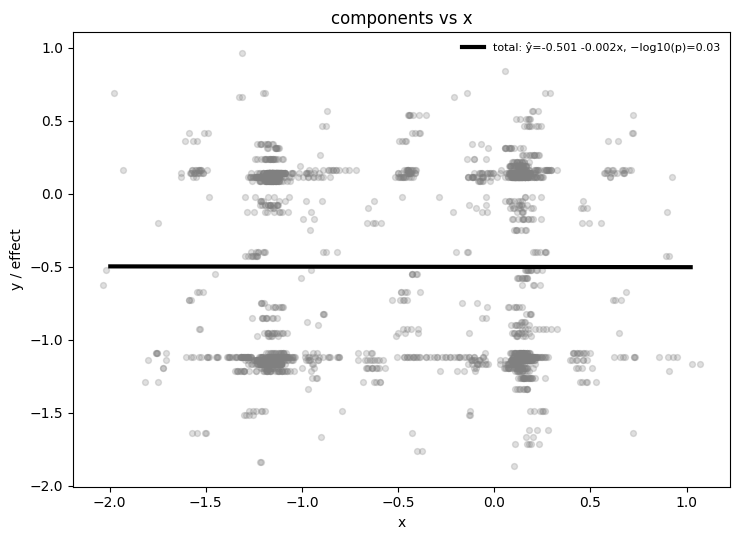

{'total': {'beta': -0.0018236390302639493,
  'intercept': -0.501161819515132,
  'neglogp': 0.030311253415093463}}

In [37]:
plot_components_vs_x(geno-corr, y, covs=None, jitter=0.03)

In [38]:
params_corr

{'snp': {'beta': 0.527282828817948,
  'intercept': 0.4989413767689834,
  'neglogp': inf},
 'pop': {'beta': -0.5089797329435355,
  'intercept': -0.48162207229782067,
  'neglogp': 115.49450879538466},
 'poly': {'beta': -0.01769712505441796,
  'intercept': -0.01674590401373401,
  'neglogp': 0.342060943573539},
 'total': {'beta': 0.0006059708199952457,
  'intercept': 0.000573400457429487,
  'neglogp': 0.006743968994860963}}

In [39]:
params_corr['total']['beta']

0.0006059708199952457

In [40]:
Expected_snp_effect = params_corr['total']['beta']*geno[chosen_snp] + params['total']['intercept']

In [41]:
Expected_snp_effect

0       0.000188
1      -0.001562
2       0.000188
3       0.000188
4       0.000188
          ...   
1995    0.000188
1996    0.000188
1997    0.000188
1998    0.000188
1999    0.000188
Name: R_7270_MAF_0.054, Length: 2000, dtype: float64

In [42]:
effects['total'].mean()

5.69008985706887e-10